(2, 472)
472 472 472


/tmp/ipykernel_23979/2034530824.py:143: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(new_points[1], new_points[0], 'bo-', markersize=0.1, color = 'red')


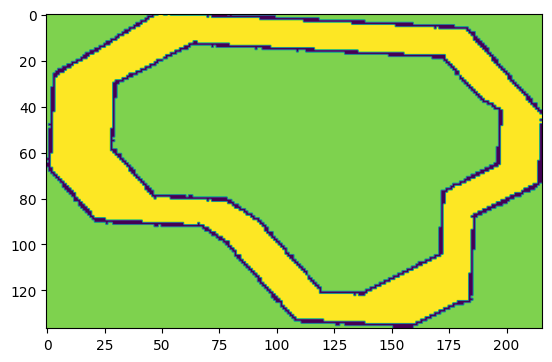

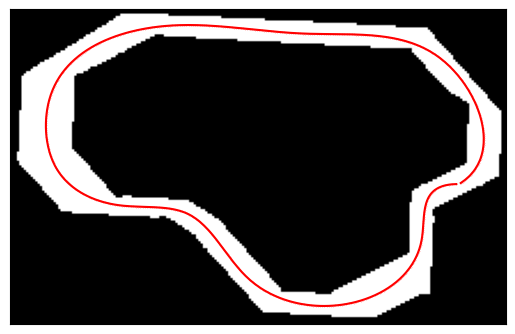

[[ 61.42933921  61.3230694   61.17039268  60.85009355  60.55311968
   60.0387159   59.61153374  58.92294994  58.37964834  57.53680918
   56.89147699  55.91430711  55.18103319  54.08945724  52.9401181
   52.09627308  51.22938225  50.34186288  49.43613223  48.51460757
   47.18910913  46.23941668  45.28218329  44.3198262   43.3547627
   42.38941004  41.4261855   40.46750632  39.51578979  38.57345316
   37.6429137   36.72618759  35.82368664  34.93542157  34.06140312
   33.20164201  32.35614896  31.5249347   30.70800996  29.90538547
   29.11707194  28.3430801   27.27295986  26.53358786  25.51247165
   24.807782    23.83575825  22.89253325  22.24297057  21.60783316
   20.73425954  20.13399203  19.3097761   18.74444099  17.96967115
   17.43933097  16.71409563  16.21881289  15.54320047  15.08303768
   14.45716335  14.03228945  13.45658601  13.06738506  12.54240904
   12.18927455  11.71558248  11.39890798  10.97705638  10.69723538
   10.32778078  10.08520682   9.85817634   9.64675687   9.451015

/tmp/ipykernel_23979/2034530824.py:173: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(world_points[1], world_points[0], 'bo-', markersize=0.1, color='red')
/tmp/ipykernel_23979/2034530824.py:174: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax.plot(world_left_points[1], world_left_points[0], 'go', markersize=0.1, color='green')
/tmp/ipykernel_23979/2034530824.py:175: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "yo" (-> color='y'). The keyword argument will take precedence.
  ax.plot(world_right_points[1], world_right_points[0], 'yo', markersize=0.1, color='blue')


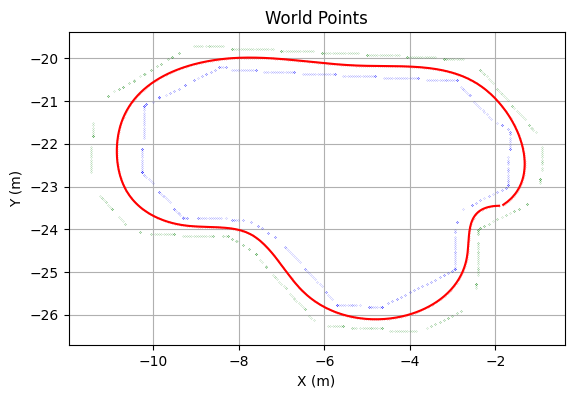

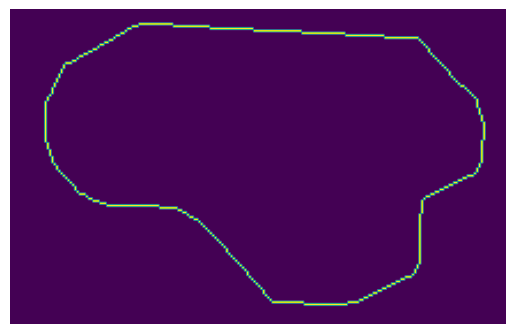

In [5]:
from skimage import data, measure
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from skimage.morphology import skeletonize
from scipy.interpolate import splprep, splev
from collections import deque
import random
import matplotlib.pyplot as plt

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2, axis=0)

# import rospy
# from nav_msgs.msg import MapMetaData

# def callback(data):
#     # d = np.array(data)
#     global res, x, y
#     res = data.resolution
#     x = data.origin.position.x
#     y = data.origin.position.y
#     print(res,x,y)

# def reader():
#     rospy.init_node('reader', anonymous=True)
#     rospy.Subscriber("map_metadata", MapMetaData, callback)
#     rospy.spin()

# reader()

res = 0.050000
x_origin = -11.606540
y_origin = -26.520793

# Read the image
img = cv.imread('shreymap.pgm', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"

ret, img = cv.threshold(img, 120, 50, cv.THRESH_TOZERO)

plt.imshow(img)

# Thresholding and preprocessing the image
x, y = img.shape
for i in range(x):
    for j in range(y):
        if 1 - img[i][j] / 255 < 0.196:
            img[i][j] = 255
        else:
            img[i][j] = 0

# Erosion to enhance contours
kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) * 6
# img = cv.dilate(img, kernel, iterations=2)
img = cv.erode(img, kernel, iterations=1)

# # Thresholding again
ret, thresh1 = cv.threshold(img, 70, 255, 0)
thresh1 = thresh1 / 255

# Skeletonize
skel1 = skeletonize(thresh1)
skeleton = skeletonize(thresh1)

# Find contours
contours = measure.find_contours(thresh1, 0.1)


# Function to find the nearest point on a contour to a given point
def find_nearest_point(contour, point):
    # print(len(contour), point.shape)
    dists = np.linalg.norm(contour - point, axis=1)
    return contour[np.argmin(dists)]

# Function to find left and right points from contours corresponding to a point on the centerline
def find_left_right_points(contours, centerline_point):
    left_point = None
    right_point = None
    i = 0
    min_dist = float('inf')

    for contour in contours:

      if i==0:
        left_point = find_nearest_point(contour, centerline_point)
        i=1
      else:
        right_point = find_nearest_point(contour, centerline_point)


    return left_point, right_point

n = np.array(skeleton.nonzero())
n = n.T

stack = deque()
randpt = random.randint(0, n.shape[0])
mid_path = []
stack.append(n[randpt])
n = np.delete(n, randpt, axis=0)
count = 0
lim1 = n.shape[0]

while len(stack) > 0 and count < lim1:
    v = stack.pop()
    try:
        idxs = np.linalg.norm(n - v, axis=1).argmin()
        i = n[idxs]
        if skel1[i[0], i[1]] > 0:
            stack.append(i)
            count = count + 1
            mid_path.append(i)
            skel1[i[0], i[1]] = 0
            n = np.delete(n, idxs, axis=0)
    except ValueError:
        pass

mid_path = np.array(mid_path)
mid_path_t = mid_path.T
tck, u = splprep([mid_path_t[0], mid_path_t[1]], s=500)
new_points = splev(u, tck)
new_points = np.array(new_points)

print(new_points.shape)


# Calculate left and right points for each point on the mid-path
left_points = []
right_points = []
for point in new_points.T:
    left_point, right_point = find_left_right_points(contours, point)
    left_points.append(left_point)
    right_points.append(right_point)

left_points = np.array(left_points).T
right_points = np.array(right_points).T

# Plotting
fig, ax = plt.subplots()
ax.imshow(img, cmap=plt.cm.gray)

ax.plot(new_points[1], new_points[0], 'bo-', markersize=0.1, color = 'red')

print(len(new_points[0]), len(left_points[0]), len(right_points[0]))

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

height, width = img.shape

new_points[0] = height-new_points[0]
world_points = new_points*res
world_points[1] = world_points[1] + x_origin
world_points[0] = world_points[0] + y_origin

left_points[0] = height - left_points[0]
world_left_points = left_points*res
world_left_points[1] = world_left_points[1] + x_origin
world_left_points[0] = world_left_points[0] + y_origin

right_points[0] = height - right_points[0]
world_right_points = right_points*res
world_right_points[1] = world_right_points[1] + x_origin
world_right_points[0] = world_right_points[0] + y_origin

print(new_points)

fig, ax = plt.subplots()
ax.plot(world_points[1], world_points[0], 'bo-', markersize=0.1, color='red')
ax.plot(world_left_points[1], world_left_points[0], 'go', markersize=0.1, color='green')
ax.plot(world_right_points[1], world_right_points[0], 'yo', markersize=0.1, color='blue')

# Set the aspect ratio to be equal to prevent stretching
ax.set_aspect('equal')

# Set labels and title
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('World Points')

# Show grid
ax.grid(True)

plt.show()

# Calculate distances between world points and world left points
left_distances = euclidean_distance(world_points, world_left_points)

# Calculate distances between world points and world right points
right_distances = euclidean_distance(world_points, world_right_points)

plt.imshow(skeleton)
plt.axis('off')  # Turn off the axis
plt.show()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
new_points[0] = height-new_points[0]
from shapely.geometry import LineString, Point

# Function to find perpendicular points on left and right contours
def find_perpendicular_points(left_contour, right_contour, center_point, window_size=5):
    left_perpendicular_points = []
    right_perpendicular_points = []

    for i, point in enumerate(center_point):
        left_window = left_contour[:, max(0, i - window_size):min(i + window_size, left_contour.shape[1])]
        right_window = right_contour[:, max(0, i - window_size):min(i + window_size, right_contour.shape[1])]

        left_line = LineString(left_window.T)
        right_line = LineString(right_window.T)

        left_point = left_line.interpolate(left_line.project(Point(point)), normalized=True)
        right_point = right_line.interpolate(right_line.project(Point(point)), normalized=True)

        left_perpendicular_points.append([left_point.x, left_point.y])
        right_perpendicular_points.append([right_point.x, right_point.y])

    return np.array(left_perpendicular_points).T, np.array(right_perpendicular_points).T

# Calculate perpendicular points on left and right contours
left_perpendicular_points, right_perpendicular_points = find_perpendicular_points(left_points, right_points, new_points.T)

# left_perpendicular_points[0] = height - left_perpendicular_points[0]
world_left_perpendicular_points = left_perpendicular_points*res
world_left_perpendicular_points[1] = world_left_perpendicular_points[1] + x_origin
world_left_perpendicular_points[0] = world_left_perpendicular_points[0] + y_origin

# right_perpendicular_points[0] = height - right_perpendicular_points[0]
world_right_perpendicular_points = right_perpendicular_points*res
world_right_perpendicular_points[1] = world_right_perpendicular_points[1] + x_origin
world_right_perpendicular_points[0] = world_right_perpendicular_points[0] + y_origin

fig, ax = plt.subplots()
ax.plot(world_points[1], world_points[0], 'bo-', markersize=0.1, color='red')
ax.plot(world_left_perpendicular_points[1], world_left_perpendicular_points[0], 'go', markersize=0.1, color='green')
ax.plot(world_right_perpendicular_points[1], world_right_perpendicular_points[0], 'yo', markersize=0.1, color='blue')

# Set the aspect ratio to be equal to prevent stretching
ax.set_aspect('equal')

# Set labels and title
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('World Points')

# Show grid
ax.grid(True)

# Set labels and title
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('World Points')

# Show grid
ax.grid(True)

plt.show()

# Calculate distances between world points and world left points
left_perpendicular_distances = euclidean_distance(world_points, world_left_perpendicular_points)

# Calculate distances between world points and world right points
right_perpendicular_distances = euclidean_distance(world_points, world_right_perpendicular_points)


In [ ]:
import csv

# Define the file path for the CSV
csv_file_path = 'raceline_perp_berlin.csv'

# Write world_points to CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file, delimiter=';')

    # Write header row
    writer.writerow(['x', 'y', 'x_left', 'y_left', 'x_right', 'y_right', 'd_left', 'd_right'])

    # Write each point to the CSV
    for x1, y1, x2, y2, x3, y3, x4, y4 in zip(world_points[1], world_points[0], world_left_perpendicular_points[1], world_left_perpendicular_points[0], world_right_perpendicular_points[1], world_right_perpendicular_points[0], left_perpendicular_distances, right_perpendicular_distances):
        writer.writerow([x1, y1, x2, y2, x3, y3, x4, y4])

print("CSV file successfully created!")
